In [29]:
import os
from utils import data_loader_utils
import tensorflow as tf#


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [30]:
machines = ["M01","M02","M03"]
process_names = ["OP00","OP01","OP02","OP03","OP04","OP05","OP06","OP07","OP08","OP09","OP10","OP11","OP12","OP13","OP14"]
labels = ["good","bad"]
path_to_dataset = "../data/"

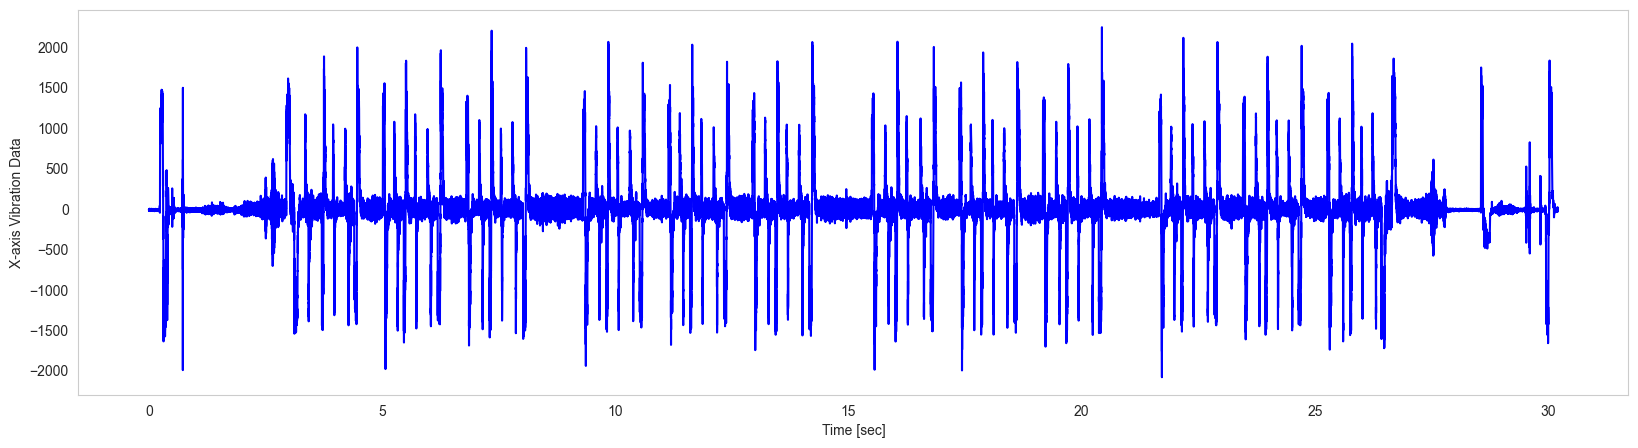

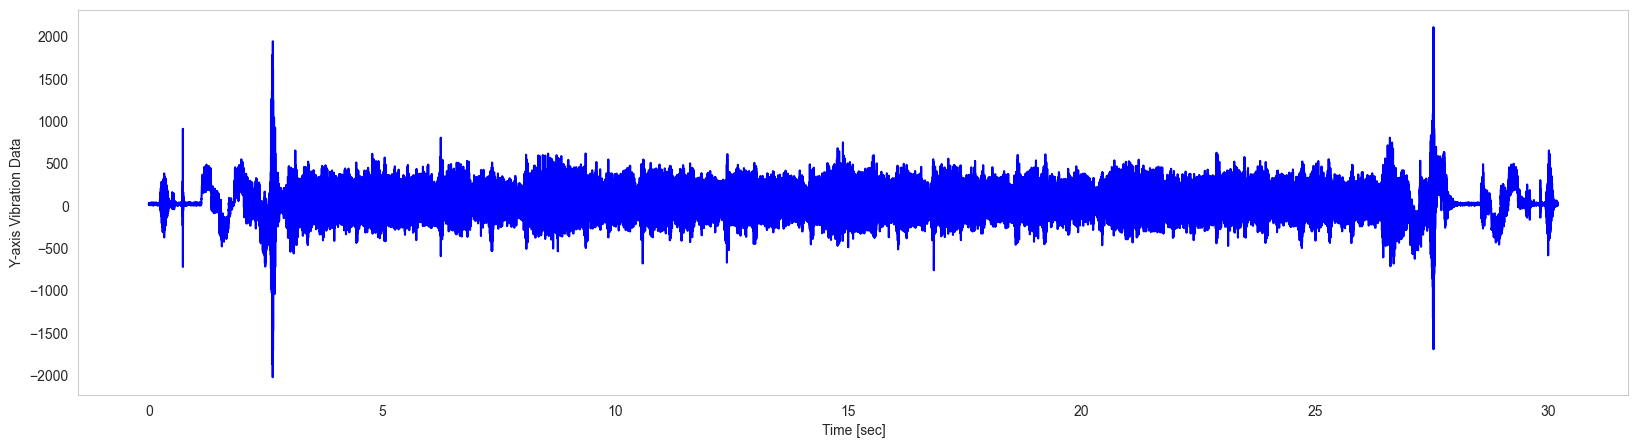

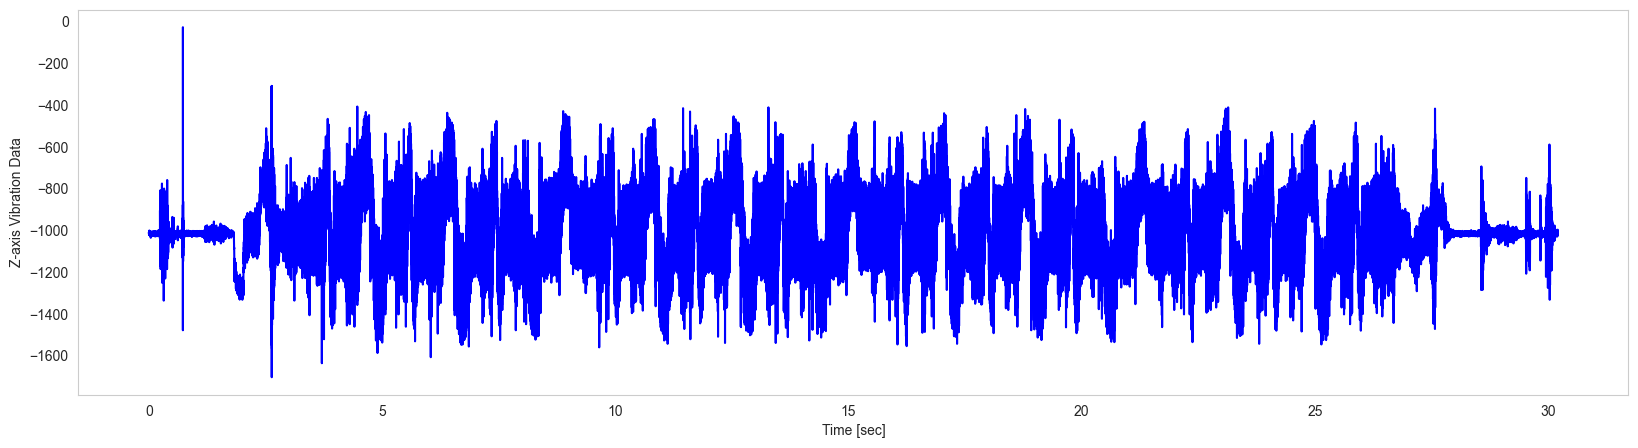

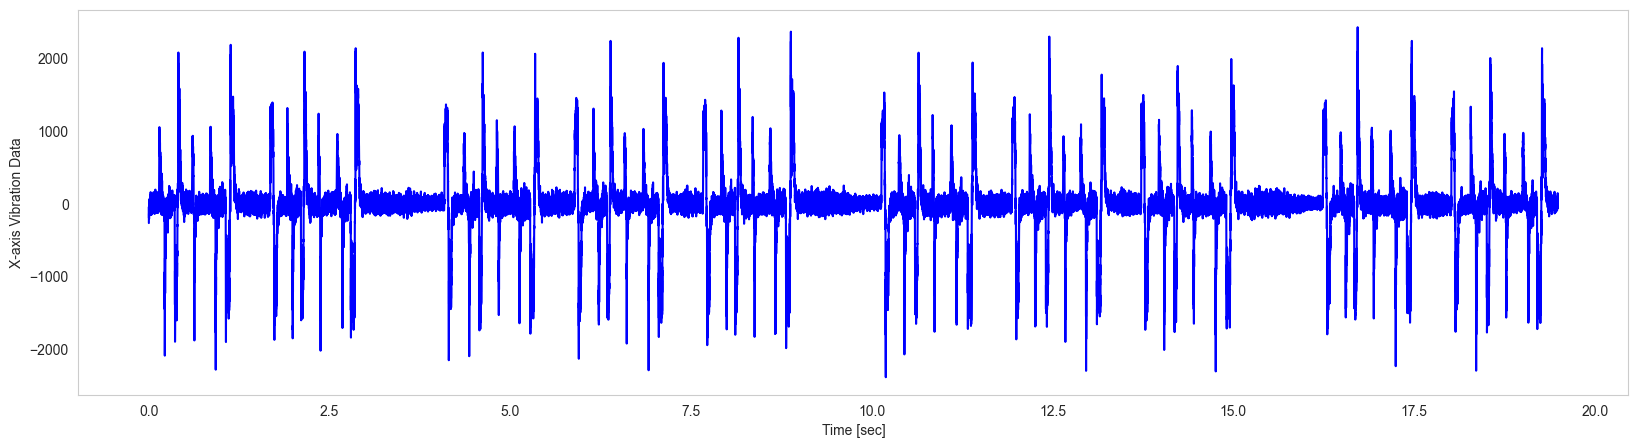

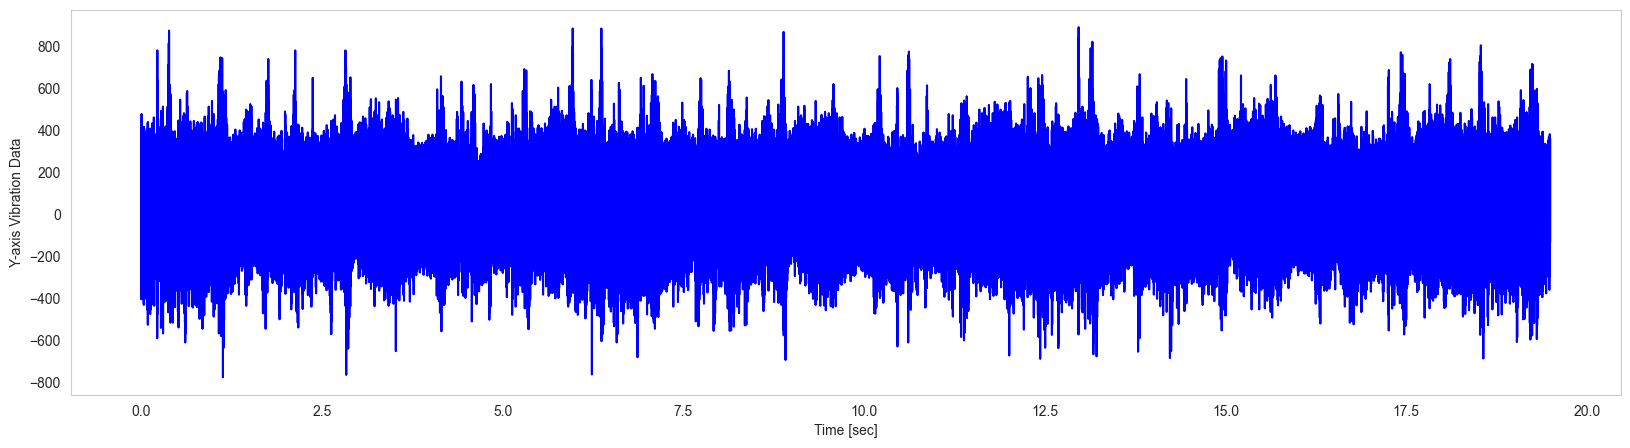

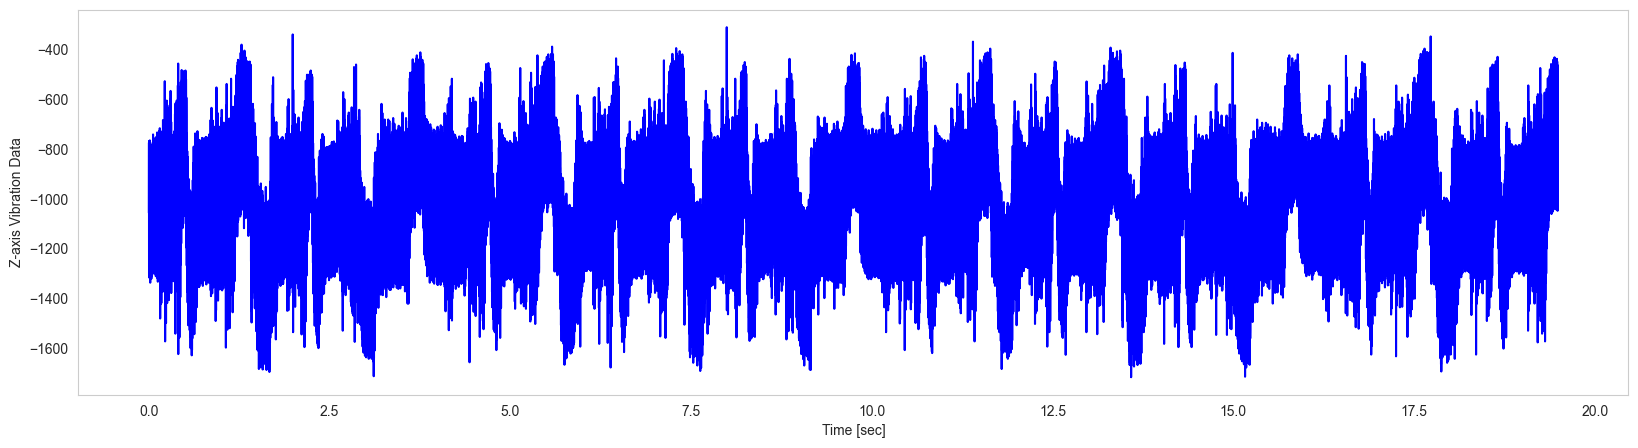

In [31]:
file="../data/M01/OP01/good/M01_Aug_2019_OP01_000.h5"
M01_Aug_2019_OP01_000_good = data_loader_utils.datafile_read(file)
M01_Aug_2019_OP01_000_bad = data_loader_utils.datafile_read("../data/M01/OP01/bad/M01_Aug_2019_OP01_000.h5")

In [32]:
import pandas as pd

# Load data as a DataFrame
df = pd.DataFrame({
    'x': M01_Aug_2019_OP01_000_good[:, 0],
    'y': M01_Aug_2019_OP01_000_good[:, 1],
    'z': M01_Aug_2019_OP01_000_good[:, 2]
})



In [33]:
_df = pd.DataFrame({
    'x': M01_Aug_2019_OP01_000_bad[:, 0],
    'y': M01_Aug_2019_OP01_000_bad[:, 1],
    'z': M01_Aug_2019_OP01_000_bad[:, 2]
})



In [34]:
_df

,x,y,z
0,-265.0,-230.0,-1056.0
1,-42.0,-320.0,-870.0
2,-58.0,-76.0,-802.0
3,-197.0,103.0,-774.0
4,-134.0,396.0,-1083.0
...,...,...,...
38978,-1.0,216.0,-685.0
38979,-58.0,359.0,-870.0
38980,-23.0,263.0,-979.0
38981,1.0,-80.0,-1036.0


In [35]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style("whitegrid")

from numpy.random import seed
#from tensorflow import set_random_seed

<function matplotlib.pyplot.show(close=None, block=None)>

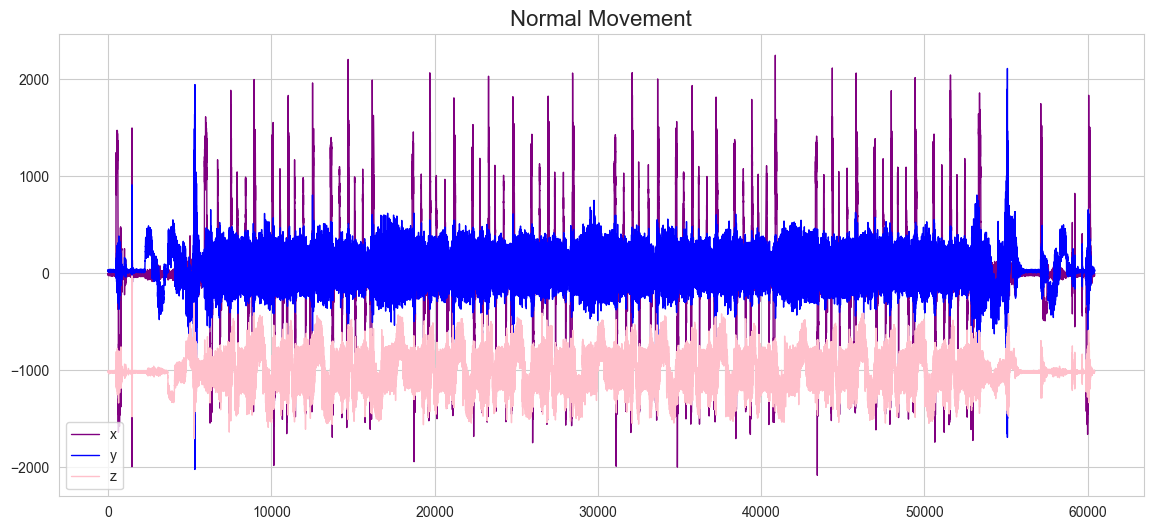

In [36]:
Normal = df
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(Normal['x'], label='x', color='purple', animated=True,linewidth=1)
ax.plot(Normal['y'], label='y', color='blue', animated=True,linewidth=1)
ax.plot(Normal['z'], label='z', color='pink', animated=True,linewidth=1)

plt.legend(loc='lower left')
ax.set_title('Normal Movement', fontsize=16)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

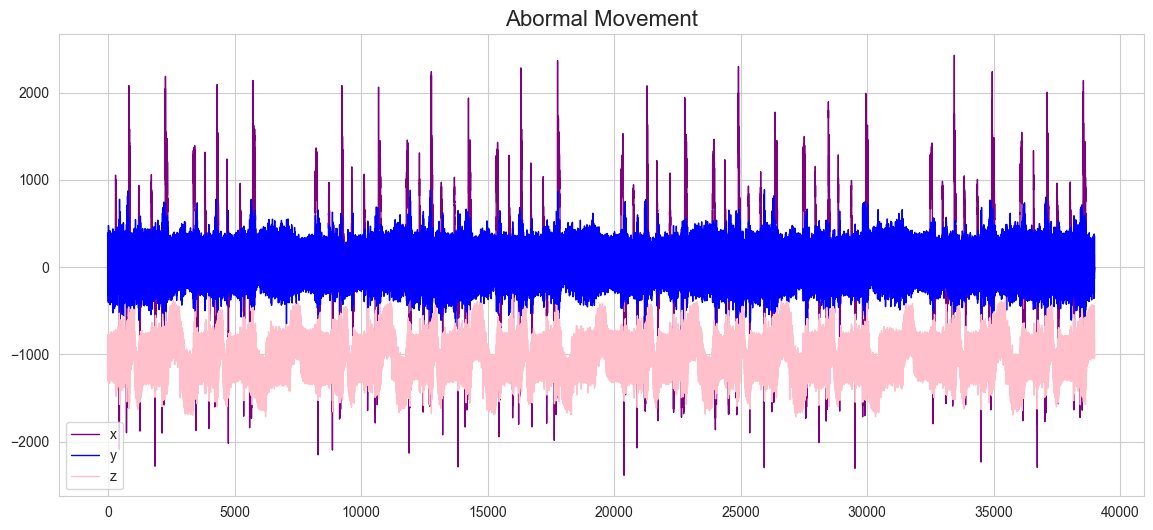

In [37]:
Abnormal = _df
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(Abnormal['x'], label='x', color='purple', animated=True,linewidth=1)
ax.plot(Abnormal['y'], label='y', color='blue', animated=True,linewidth=1)
ax.plot(Abnormal['z'], label='z', color='pink', animated=True,linewidth=1)

plt.legend(loc='lower left')
ax.set_title('Abormal Movement', fontsize=16)
plt.show

In [38]:
train = Normal
test = Abnormal
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (60416, 3)
Test dataset shape: (38983, 3)


In [39]:
# transforming data from the time domain to the frequency domain using fast Fourier transform
train_fft = np.fft.fft(Normal)
test_fft = np.fft.fft(Abnormal)

In [40]:
X_train = train.to_numpy()
X_test = test.to_numpy()

In [41]:
X_train.shape

(60416, 3)

In [42]:
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


In [44]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))  
    L1 = LSTM(32, activation='relu', return_sequences=True,
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(16, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(16, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(32, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

In [45]:
# create the autoencoder model
tf.random.set_seed(1234)
model = autoencoder_model(X_train_reshaped)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 1, 3)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 1, 32)               │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_2 (RepeatVector)       │ (None, 1, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 1, 16)               │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 1, 32)               │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 1, 3)                │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,227 (63.39 KB)

 Trainable params: 16,227 (63.39 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# fit the model to the data
nb_epochs = 10
batch_size = 10
history = model.fit(X_train_reshaped, X_train_reshaped, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 4.8150 - val_loss: 1.4981
Epoch 2/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 3.8181 - val_loss: 3.5895
Epoch 3/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 3.5781 - val_loss: 1.6303
Epoch 4/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 3.1993 - val_loss: 2.8310
Epoch 5/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 3.2907 - val_loss: 4.0121
Epoch 6/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 3.3199 - val_loss: 1.7888
Epoch 7/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 3.1006 - val_loss: 2.7409
Epoch 8/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 2.9994 - val_loss: 3.3962
Epoch 9/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 3.1263 - val_loss: 3.5799
Epoch 10/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 2.9192 - val_loss: 1.8236


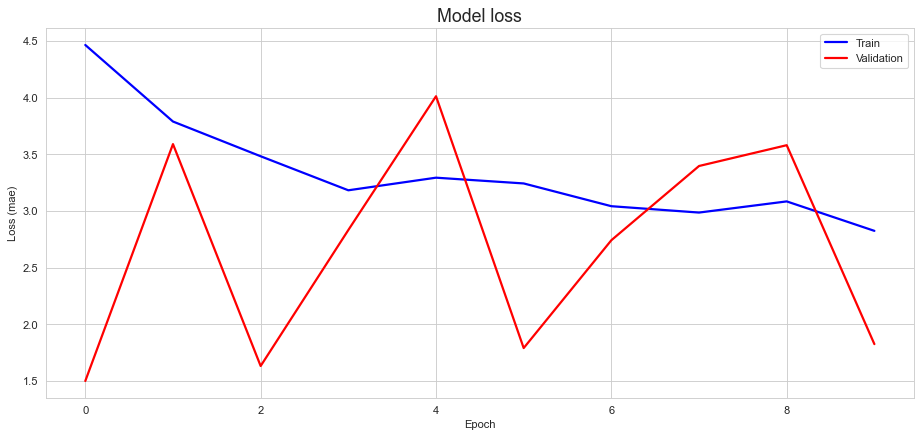

In [48]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [60]:
X_pred_train = model.predict(X_train_reshaped)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index




1888/1888 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [61]:
scored_train = pd.DataFrame(index=train.index)
scored_train.shape

(60416, 0)

In [64]:
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train - X_train), axis=1)
scored_train['Threshold'] = 0.018
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']


C:\Users\Rj\AppData\Local\Temp\ipykernel_15920\3964645576.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored_train['Loss_mae'], bins = 20, kde= True, color = 'blue');


<Axes: >

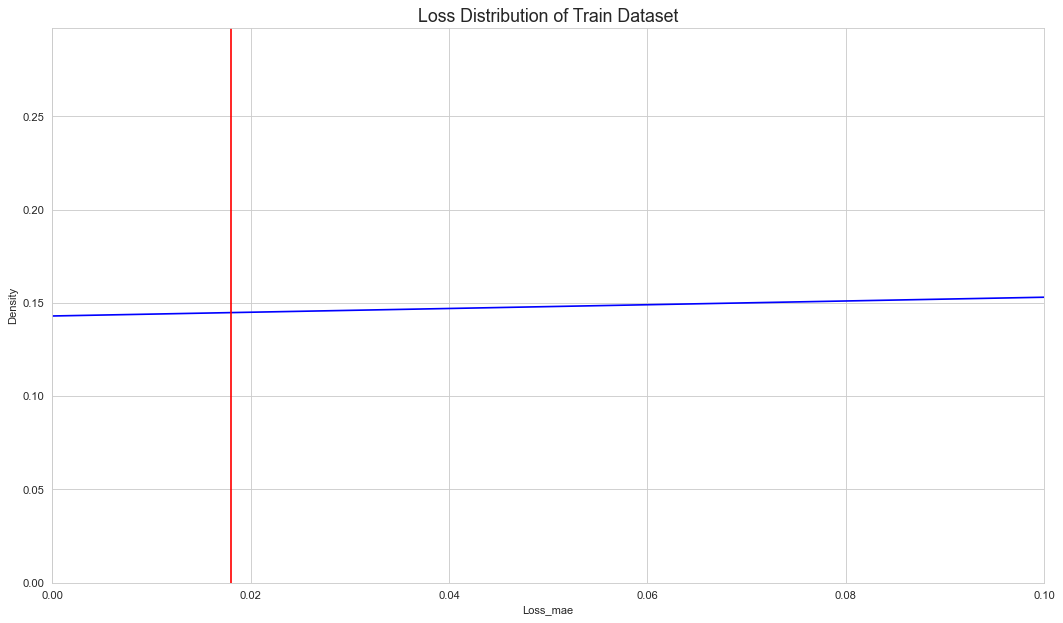

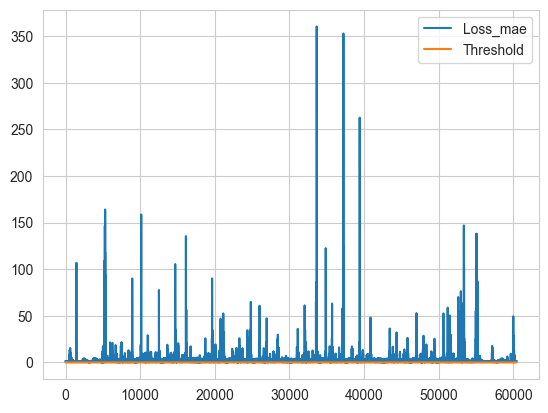

In [65]:

plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution of Train Dataset', fontsize=16)
sns.distplot(scored_train['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.axvline(x=scored_train['Threshold'][0], color='r', linestyle='-')
#plt.xlim([0.0,.5])
plt.xlim([0.0,.1])
scored_train.plot()

In [66]:
train_pred = pd.DataFrame(X_pred_train, columns=train.columns)
train_pred.index = train.index

model_anomalies = train.iloc[scored_train.index[scored_train['Anomaly']==True]]

<function matplotlib.pyplot.show(close=None, block=None)>

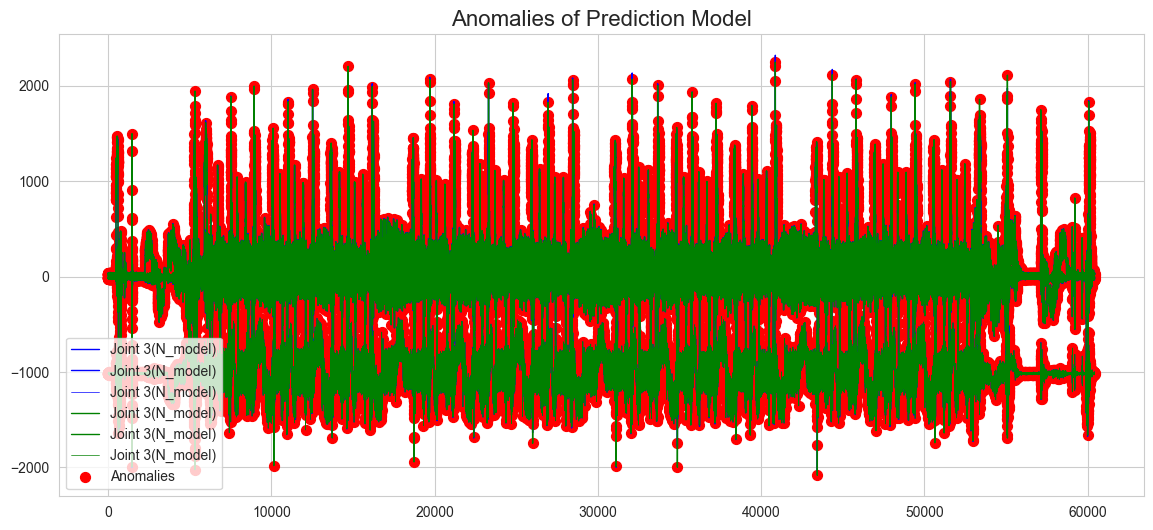

In [72]:
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(train_pred['x'], label='Joint 3(N_model)', color='blue', linewidth=1)
ax.plot(train_pred['y'], label='Joint 3(N_model)', color='blue', linewidth=1)
ax.plot(train_pred['z'], label='Joint 3(N_model)', color='blue', linewidth=0.5)

ax.plot(train['x'], label='Joint 3(N_model)', color='green', linewidth=1)
ax.plot(train['y'], label='Joint 3(N_model)', color='green', linewidth=1)
ax.plot(train['z'], label='Joint 3(N_model)', color='green', linewidth=0.5)

ax.scatter(model_anomalies.index, model_anomalies['x'], label='Anomalies', color='red', alpha=1, s=50)
ax.scatter(model_anomalies.index, model_anomalies['y'], color='red', alpha=1, s=50)
ax.scatter(model_anomalies.index, model_anomalies['z'], color='red', alpha=1, s=50)

plt.legend(loc='lower left')
ax.set_title('Anomalies of Prediction Model', fontsize=16)
plt.show

In [73]:
X_pred_test = model.predict(X_test)
X_pred_test = X_pred_test.reshape(X_pred_test.shape[0], X_pred_test.shape[2])
X_pred_test = pd.DataFrame(X_pred_test, columns=train.columns)
X_pred_test.index = test.index

1219/1219 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [74]:
scored_test = pd.DataFrame(index=train.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])

In [75]:
scored_test['Loss_mae'] = np.mean(np.abs(X_pred_test-Xtest), axis = 1)
scored_test['Threshold'] = scored_train['Threshold']
scored_test['Anomaly'] = scored_test['Loss_mae'] > scored_test['Threshold']

C:\Users\Rj\AppData\Local\Temp\ipykernel_15920\3654972900.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored_test['Loss_mae'], bins = 20, kde= True, color = 'blue');


<Axes: >

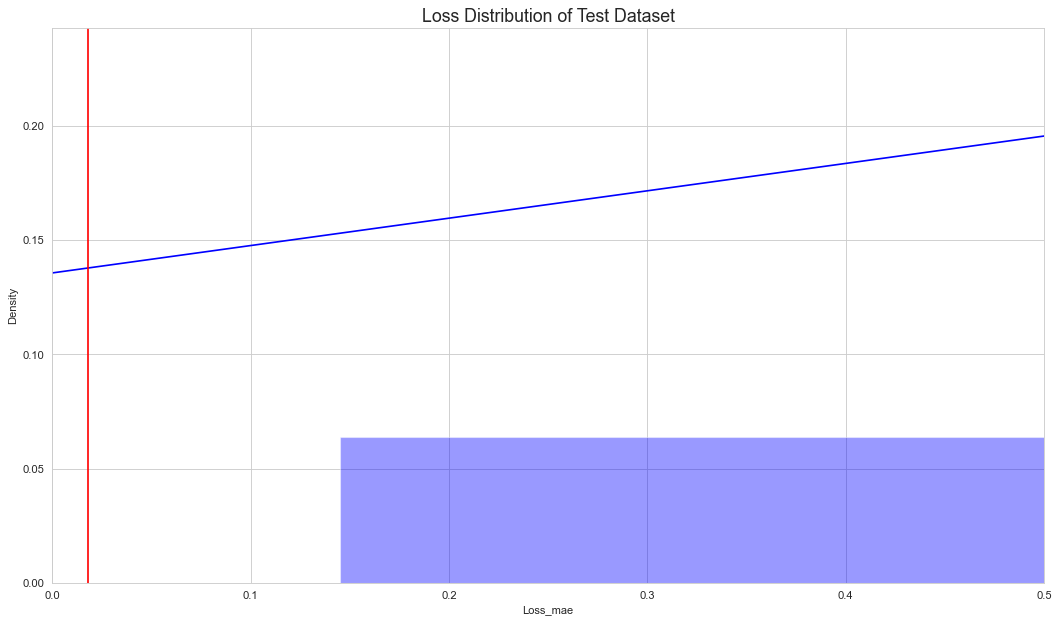

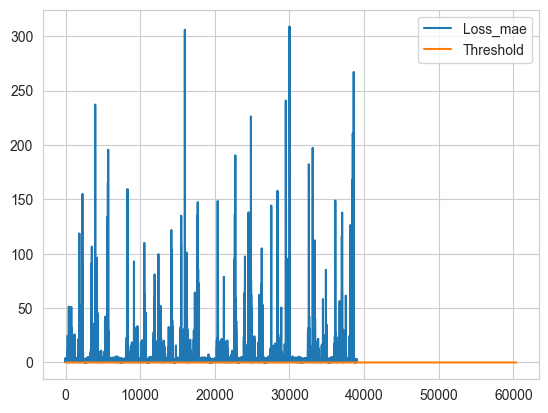

In [76]:
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution of Test Dataset', fontsize=16)
sns.distplot(scored_test['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.axvline(x=scored_test['Threshold'][0], color='r', linestyle='-')
plt.xlim([0.0,.5])
scored_test.plot()

In [77]:
print("Number of Anomalies found: \n", scored_test['Anomaly'].value_counts())
print("\nLocation of Anomalies found: \n", scored_test.index[scored_test['Anomaly']==True])

Number of Anomalies found: 
 Anomaly
True     38983
False    21433
Name: count, dtype: int64

Location of Anomalies found: 
 Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       38973, 38974, 38975, 38976, 38977, 38978, 38979, 38980, 38981, 38982],
      dtype='int64', length=38983)


In [ ]:
test_pred = pd.DataFrame(X_pred_test, columns=test.columns)
test_pred.index = test.index

anomalies = test.iloc[scored_test.index[scored_test['Anomaly']==True]]

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(test_pred['x'], label='Joint 1(N_model)', color='blue', linewidth=1)
ax.plot(test_pred['y'], label='Joint 2(N_model)', color='blue', linewidth=1)
ax.plot(test_pred['z'], label='Joint 3(N_model)', color='blue', linewidth=0.5)


ax.plot(test['x'], label='Joint 1(AN_x)', color='green', linewidth=1)
ax.plot(test['y'], label='Joint 2(AN_x)', color='green', linewidth=1)
ax.plot(test['z'], label='Joint 3(AN_x)', color='green', linewidth=0.5)


ax.scatter(anomalies.index, anomalies['x'], label='Anomalies', color='red', alpha=1, s=50)
ax.scatter(anomalies.index, anomalies['y'], color='red', alpha=1, s=50)
ax.scatter(anomalies.index, anomalies['z'], color='red', alpha=1, s=50)

plt.legend(loc='lower left')
ax.set_title('Movement Anomalies', fontsize=16)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>